# Prediction of Rental Prices in the German Real Estate Market

**Data Description:**

The data was scraped from Immoscout24, the biggest real estate platform in Germany. Immoscout24 has listings for both rental properties and homes for sale, however, the data only contains offers for rental properties.

[Kaggle Page](https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany/data)

The data set contains most of the important properties, such as living area size, the rent, both base rent as well as total rent (if applicable), the location (street and house number, if available, ZIP code and state), type of energy etc. It also has two variables containing longer free text `descriptions` which is just text describing the offer and `facilities` describing all available facilities, newest renovation etc.

**Task Overview:**

The task is divided into two main parts, focusing on machine learning model development for rent prediction:

1. Predicting Rent with Structural Data: Develop a machine learning model to predict the total rent using only the structural data. Exclude the `description` and `facilities` text fields for this model.
2. Predicting Rent with Structural and Text Data: Create a second machine learning model that predicts the total rent using both structural and text data (`description` and `facilities`). It is encouraged using modern generative AI techniques for processing text data.

## Necessary imports and load the dataset

This notebook was prepared to run on the Google Colab with a free tier T4 GPU

In [ ]:
# Necessary imports for the regression task with structured data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import  train_test_split
from catboost import CatBoostRegressor, Pool, cv
import time

In [ ]:
# Main data directory on Google Drive for this task
data_directory = 'your-data-directory'
data_file_name = 'immo_data.csv'

# Load data into DataFrame
pd.set_option('display.max_columns', None)
df = pd.read_csv(os.path.join(data_directory, data_file_name))
df.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [3]:
# Drop duplicates
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [4]:
df.describe(include='all')

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
count,268850,261941.000000,223994,236231,45020.0,268850,268850,268850.000000,267018.000000,235492.000000,2.283330e+05,211805.000000,2.688500e+05,93052.000000,211886,268850,268850,268850,211805.000000,2.688500e+05,197832,268850.000000,268850,200361,156185,154277,268850,197837,268850,268850.000000,232236,268850.000000,268850.000000,162344.000000,217541.000000,171118.000000,268850.000000,268850,268850.000000,268850,268850,249103,215926,85518.000000,77787,80711.000000,46846.000000,46846.000000,268850
unique,16,NaN,13,3,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132,2,16,2,NaN,NaN,5510,NaN,419,10,4,3,52373,54490,2,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,419,8684,212621,189526,NaN,10,NaN,NaN,NaN,4
top,Nordrhein_Westfalen,NaN,central_heating,ONE_YEAR_FREE,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas,False,Nordrhein_Westfalen,True,NaN,NaN,1,NaN,Leipzig,well_kept,normal,negotiable,no_information,Hauptstraße,False,NaN,apartment,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Leipzig,Innenstadt,+ MEIN GUENTZ - Quartier der Generationen\r\n+...,Laminat,NaN,C,NaN,NaN,NaN,Feb20
freq,62863,NaN,128977,227632,NaN,247679,165734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110899,176794,62863,172235,NaN,NaN,7173,NaN,13723,66591,81826,91970,71013,911,205528,NaN,131522,NaN,NaN,NaN,NaN,NaN,NaN,216093,NaN,13723,4751,216,207,NaN,14613,NaN,NaN,NaN,79276
mean,NaN,151.206113,NaN,NaN,10.0,NaN,NaN,9.791958,3.389001,28.804928,9.013315e+02,1966.400590,1.069697e+08,1.327634,NaN,NaN,NaN,NaN,3.714544,6.941294e+02,NaN,74.355548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.765256,NaN,37283.022235,2.641261,114.749533,2.122405,3.572319,2.571542,NaN,3.070790,NaN,NaN,NaN,NaN,76.990866,NaN,2013.904536,89.113612,0.199769,NaN
std,NaN,308.295790,NaN,NaN,0.0,NaN,NaN,6.408399,1.964874,16.337151,3.323833e+04,46.992207,1.250093e+07,8.361403,NaN,NaN,NaN,NaN,2.738134,1.953602e+04,NaN,254.759208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.214357,NaN,27798.037296,2.633440,61.653663,3.634934,6.375496,0.937594,NaN,1.407127,NaN,NaN,NaN,NaN,147.716278,NaN,10.963125,5.395805,0.009667,NaN
min,NaN,0.000000,NaN,NaN,10.0,NaN,NaN,0.000000,-12.330000,1.000000,0.000000e+00,1000.000000,2.887174e+07,0.000000,NaN,NaN,NaN,NaN,1.000000,0.000000e+00,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,852.000000,1.000000,0.100000,-1.000000,0.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,1015.000000,71.430000,0.170500,NaN
25%,NaN,95.000000,NaN,NaN,10.0,NaN,NaN,6.000000,2.000000,10.000000,4.698000e+02,1950.000000,1.066910e+08,1.000000,NaN,NaN,NaN,NaN,1.000000,3.380000e+02,NaN,54.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,9128.000000,2.000000,79.000000,1.000000,2.000000,2.000000,NaN,2.000000,NaN,NaN,NaN,NaN,54.000000,NaN,2012.000000,90.760000,0.191500,NaN
50%,NaN,135.000000,NaN,NaN,10.0,NaN,NaN,9.000000,3.390000,40.000000,6.500000e+02,1973.000000,1.111584e+08,1.000000,NaN,NaN,NaN,NaN,3.000000,4.900000e+02,NaN,67.320000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,38667.000000,3.000000,107.000000,2.000000,3.000000,3.000000,NaN,3.000000,NaN,NaN,NaN,NaN,70.000000,NaN,2017.000000,90.760000,0.198500,NaN
75%,NaN,190.000000,NaN,NaN,10.0,NaN,NaN,13.000000,4.570000,40.000000,9.850000e+02,1996.000000,1.137688e+08,1.000000,NaN,NaN,NaN,NaN,5.000000,7.990000e+02,NaN,87.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,57072.000000,3.000000,140.300000,3.000000,4.000000,3.000000,NaN,4.000000,NaN,NaN,NaN,NaN,90.000000,NaN,2019.000000,90.760000,0.205500,NaN


In [5]:
def check_missing_values(df):
    """
    Checks for missing values in a Pandas DataFrame and prints the number and percentage of missing values for each column.
    """

    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    missing_values_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_percentage
    })
    return missing_values_df.sort_values(by='Percentage',ascending=False).reset_index(names='Column')

df_na_info = check_missing_values(df)
df_na_info

,Column,Missing Values,Percentage
0,telekomHybridUploadSpeed,223830,83.254603
1,electricityBasePrice,222004,82.575414
2,electricityKwhPrice,222004,82.575414
3,energyEfficiencyClass,191063,71.066766
4,lastRefurbish,188139,69.979171
5,heatingCosts,183332,68.191185
6,noParkSpaces,175798,65.388879
7,petsAllowed,114573,42.615957
8,interiorQual,112665,41.906267
9,thermalChar,106506,39.615399


## Data Preprocessing and Feature Selection

In [6]:
# Drop all features with more than 1/3 missing data
df_clean = df.drop(df_na_info[df_na_info['Percentage'] > 33]['Column'],axis=1)

# Drop unnecessary features
df_clean = df_clean.drop(['scoutId','picturecount','geo_bln','geo_krs','street','noRoomsRange','yearConstructedRange','baseRentRange','livingSpaceRange', 'houseNumber', 'date', 'regio3', 'firingTypes'],axis=1)

# Generally, it can be considered that totalRent = baseRent + serviceCharge
# For this reason, these two columns will be dropped and not used for prediction
df_clean = df_clean.drop(['baseRent','serviceCharge'],axis=1)

# Use postal codes as strings
df_clean['geo_plz'] = df_clean['geo_plz'].astype(str)

# Drop rows where 'totalRent' is NA
df_clean.dropna(subset=['totalRent'], inplace=True)

# Drop rows where 'totalRent' is equal to 0
df_clean = df_clean[df_clean['totalRent'] != 0]

# New shape of the clean data
df_clean.shape

(228097, 23)

Some of the drop columns are exact duplicates or binned versions of others. The remaining ones were either did not make so much sense to include (e.g. `houseNumber`) or they were too complex to handle and process for this task (e.g. `firingTypes`).

In [7]:
df_clean.describe(include='all')

,regio1,heatingType,telekomTvOffer,newlyConst,balcony,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,hasKitchen,cellar,livingSpace,condition,streetPlain,lift,typeOfFlat,geo_plz,noRooms,floor,garden,regio2,description,facilities
count,228097,191285,200697,228097,228097,226489.000000,200077.000000,2.280970e+05,178839.000000,228097,228097,228097.000000,171246,174171,228097,197548,228097,228097.000000,187745.000000,228097,228097,212142,184021
unique,16,13,3,2,2,NaN,NaN,NaN,NaN,2,2,NaN,10,50046,2,10,7369,NaN,NaN,2,419,180590,161924
top,Sachsen,central_heating,ONE_YEAR_FREE,False,True,NaN,NaN,NaN,NaN,False,True,NaN,well_kept,Hauptstraße,False,apartment,9130,NaN,NaN,False,Leipzig,saniertes Mehrfamilienhaus,Laminat
freq,52052,109633,193461,210708,141115,NaN,NaN,NaN,NaN,148319,147508,NaN,55522,805,173793,110966,1859,NaN,NaN,181988,12578,199,197
mean,NaN,NaN,NaN,NaN,NaN,3.395731,28.930261,9.022641e+02,1965.711746,NaN,NaN,73.685717,NaN,NaN,NaN,NaN,NaN,2.619414,2.132249,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,2.001650,16.301211,3.325551e+04,47.863269,NaN,NaN,273.898758,NaN,NaN,NaN,NaN,NaN,1.726794,3.555394,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,-12.330000,1.000000,1.000000e+00,1000.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.960000,10.000000,4.700000e+02,1940.000000,NaN,NaN,54.000000,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,3.390000,40.000000,6.500000e+02,1972.000000,NaN,NaN,67.000000,NaN,NaN,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,4.600000,40.000000,9.850000e+02,1996.000000,NaN,NaN,86.000000,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000,NaN,NaN,NaN,NaN


Predefine the column types for an easier handling of the features for later use.

In [8]:
NUMERICAL_COLUMNS = df_clean.select_dtypes(include=['int64', 'float64']).columns
TEXT_COLUMNS = ["description", "facilities"]
# Create categorical columns excluding free text fields
CATEGORICAL_COLUMNS = df_clean.select_dtypes(include=['object']).columns
CATEGORICAL_COLUMNS = [col for col in CATEGORICAL_COLUMNS if col not in TEXT_COLUMNS]

BOOLEAN_COLUMNS = df_clean.select_dtypes(include=['bool']).columns
print("Numerical Columns:")
print(NUMERICAL_COLUMNS)
print("Text Columns:")
print(TEXT_COLUMNS)
print("\nCategorical Columns:")
print(CATEGORICAL_COLUMNS)
print("\nBoolean Columns:")
print(BOOLEAN_COLUMNS)

Numerical Columns:
Index(['pricetrend', 'telekomUploadSpeed', 'totalRent', 'yearConstructed',
       'livingSpace', 'noRooms', 'floor'],
      dtype='object')
Text Columns:
['description', 'facilities']

Categorical Columns:
['regio1', 'heatingType', 'telekomTvOffer', 'condition', 'streetPlain', 'typeOfFlat', 'geo_plz', 'regio2']

Boolean Columns:
Index(['newlyConst', 'balcony', 'hasKitchen', 'cellar', 'lift', 'garden'], dtype='object')


### Numerical Variables

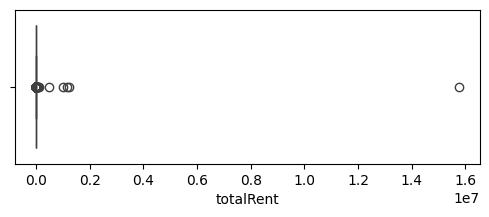

In [9]:
# Boxplot of totalRent
plt.figure(figsize=(6,2))
sns.boxplot(x = df_clean['totalRent'])
plt.show()

There seems to be extreme values (over 1 million euro rent), which can complicate the process.

New Shape:  (228084, 23)


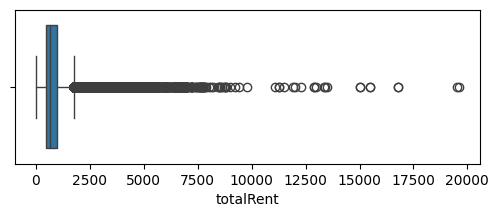

In [10]:
# Remove the extreme rents (i.e. greater than 20000 EUR)
df_clean = df_clean[df_clean['totalRent'] <= 20000]
plt.figure(figsize=(6,2))
sns.boxplot(x = df_clean['totalRent'])
print("New Shape: ", df_clean.shape)
plt.show()

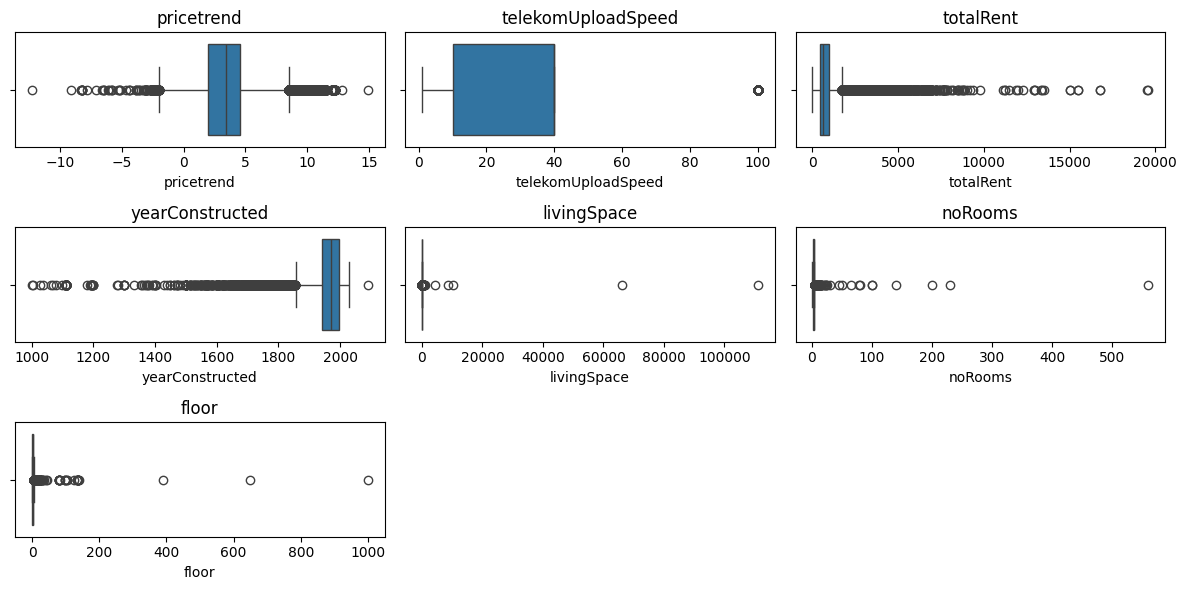

In [11]:
def create_box_plots(df, numerical_columns):
    """
    Creates box plots for each numerical column in the DataFrame.
    """
    num_cols = len(numerical_columns)
    num_rows = (num_cols + 2) // 3  # Calculate the number of rows for the subplot grid

    plt.figure(figsize=(12, 2 * num_rows))

    for i, col in enumerate(numerical_columns):
        plt.subplot(num_rows, 3, i + 1)
        sns.boxplot(x=df_clean[col])
        plt.title(col)

    plt.tight_layout()
    plt.show()

create_box_plots(df_clean, NUMERICAL_COLUMNS)

I decided to go with a bit more sophisticated approach for handling outliers in our numerical features.

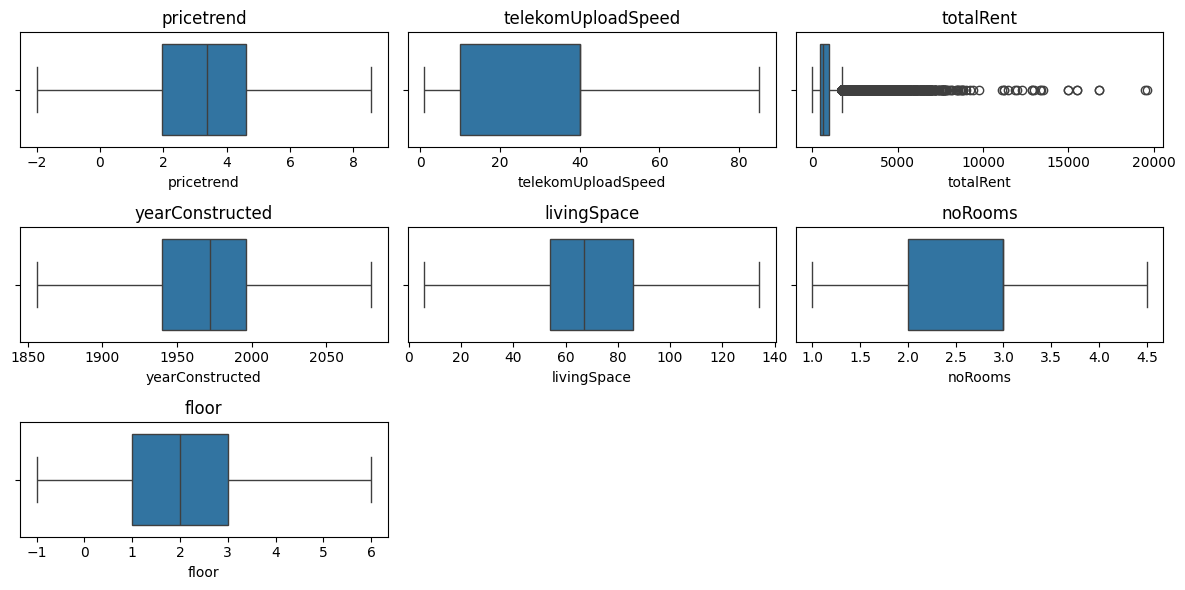

In [12]:
def handle_outliers(df, numerical_columns):
    """
    Handles outliers in numerical columns of the DataFrame, except for 'totalRent'.
    """
    for col in numerical_columns:
        if col != 'totalRent':
            # Calculate Q1, Q3, and IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            # Define bounds for outlier
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Replace outliers with the bounds
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

df_clean = handle_outliers(df_clean, NUMERICAL_COLUMNS)
create_box_plots(df_clean, NUMERICAL_COLUMNS)

For simplicity, I just decided to replace the outliers with upper and lower bounds instead of keepin them or throwing them away. 

In [13]:
def fill_na_with_mean(df, numerical_columns):
    """
    Fills missing numerical values with their respective column means.
    """
    for col in numerical_columns:
        if col in df.columns:  # Check if column exists
          if df[col].isnull().any():
              df.fillna({col: df[col].mean()}, inplace=True)
    return df

df_clean = fill_na_with_mean(df_clean, NUMERICAL_COLUMNS)

The missing values are replaced with their column means, so all of if has the same data count now.

In [14]:
df_clean[NUMERICAL_COLUMNS].describe()

,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,livingSpace,noRooms,floor
count,228084.000000,228084.000000,228084.000000,228084.000000,228084.000000,228084.000000,228084.000000
mean,3.380244,28.920213,814.563052,1966.879786,71.436959,2.586389,2.056457
std,1.941494,15.231020,560.856124,34.861170,26.727238,0.904375,1.301106
min,-2.000000,1.000000,1.000000,1856.000000,6.000000,1.000000,-1.000000
25%,1.960000,10.000000,470.000000,1957.000000,54.000000,2.000000,1.000000
50%,3.380244,40.000000,650.000000,1966.879786,67.000000,3.000000,2.000000
75%,4.600000,40.000000,985.000000,1992.000000,86.000000,3.000000,3.000000
max,8.560000,85.000000,19600.000000,2080.000000,134.000000,4.500000,6.000000


#### Correlation Matrix and Pair Plots

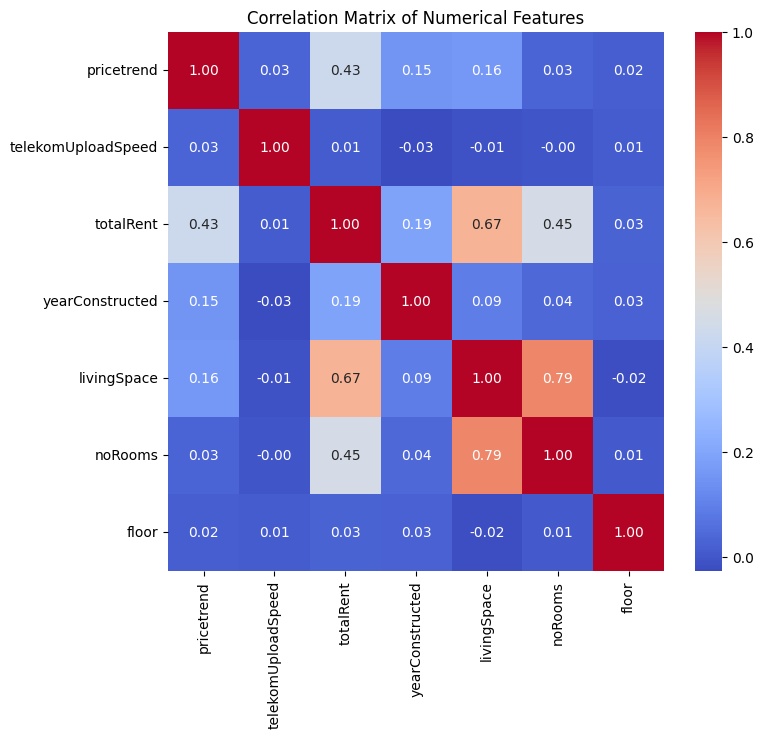

In [15]:
# Create and visualize the correlation matrix
plt.figure(figsize=(8, 7))
sns.heatmap(df_clean[NUMERICAL_COLUMNS].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The `livingSpace` has, unsurprisingly, the strongest correlation with the `totalRent`. `priceTrend` and `noRooms` has somewhat realation as well. `telekomUploadSpeed` and `floor` seems to have almost no correlation with our target value and might make sense to just discard them for predictions.

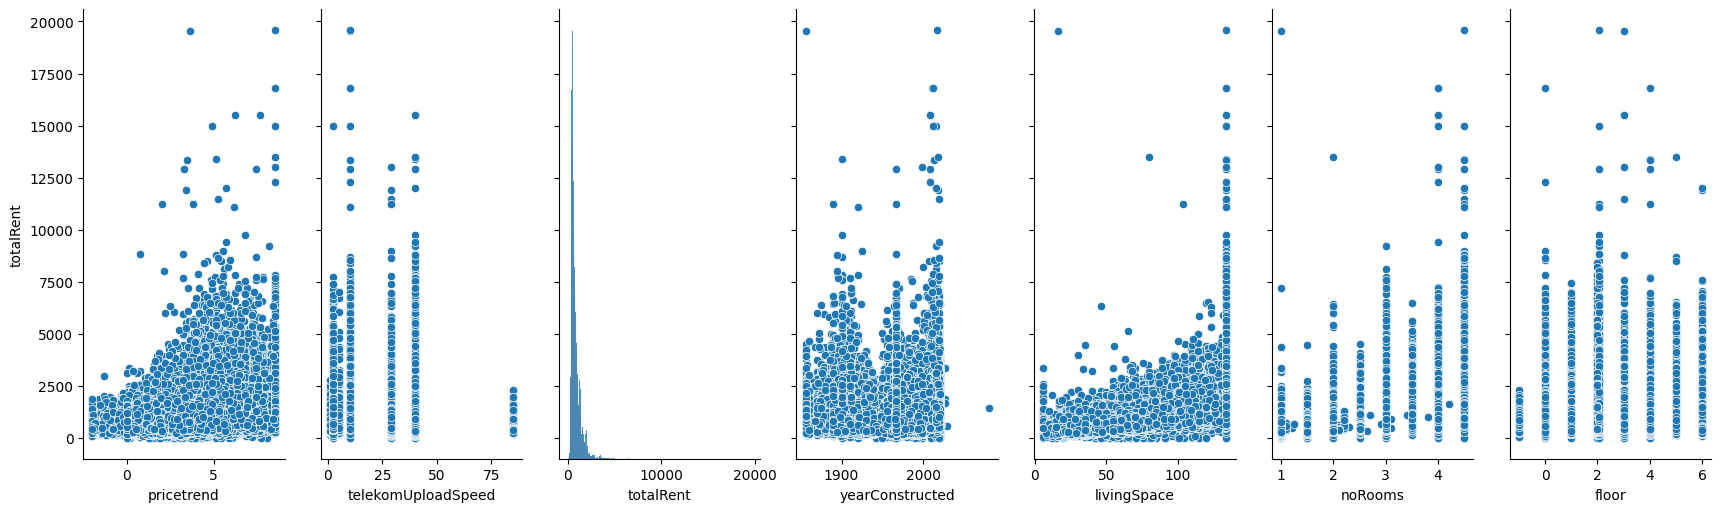

In [16]:
# Create a pairplot of the numerical variables in relation with the totalRent column
pp = sns.pairplot(df_clean, x_vars=NUMERICAL_COLUMNS, y_vars=['totalRent'])
pp.fig.set_figheight(6)
plt.show()

We can see that the features `telekomUploadSpeed`, `noRooms`, and `floor` are in fact categorical variables.

In [ ]:
# Convert 'noRooms' to object type
# df_clean['noRooms'] = df_clean['noRooms'].astype('object').astype(str)

### Boolean Variables

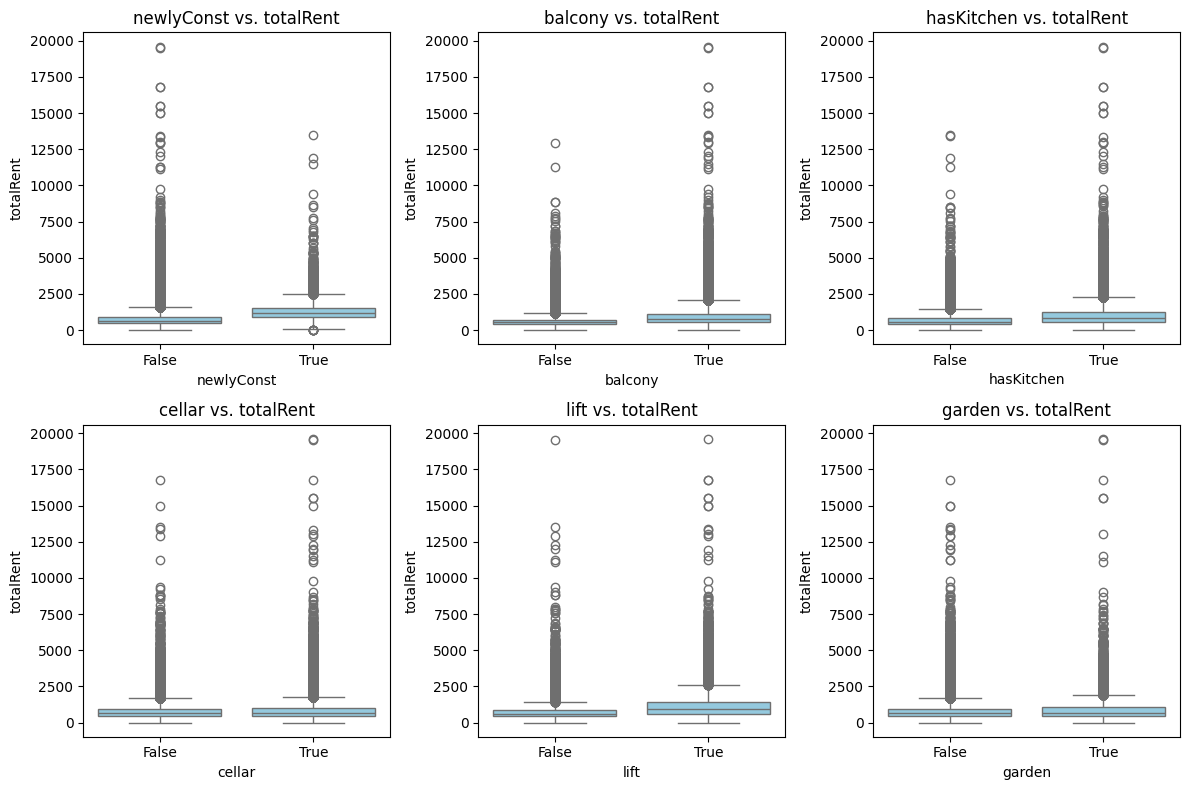

In [17]:
def create_boolean_boxplots(df, boolean_columns, target_column):
    """
    Creates box plots for each boolean column with respect to the target column.
    """
    num_cols = len(boolean_columns)
    num_rows = (num_cols + 2) // 3  # Calculate the number of rows for the subplot grid

    fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    for i, col in enumerate(boolean_columns):
        sns.boxplot(x=df[col], y=df[target_column], ax=axes[i], color="skyblue")
        axes[i].set_title(f'{col} vs. {target_column}')

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


create_boolean_boxplots(df_clean, BOOLEAN_COLUMNS, 'totalRent')

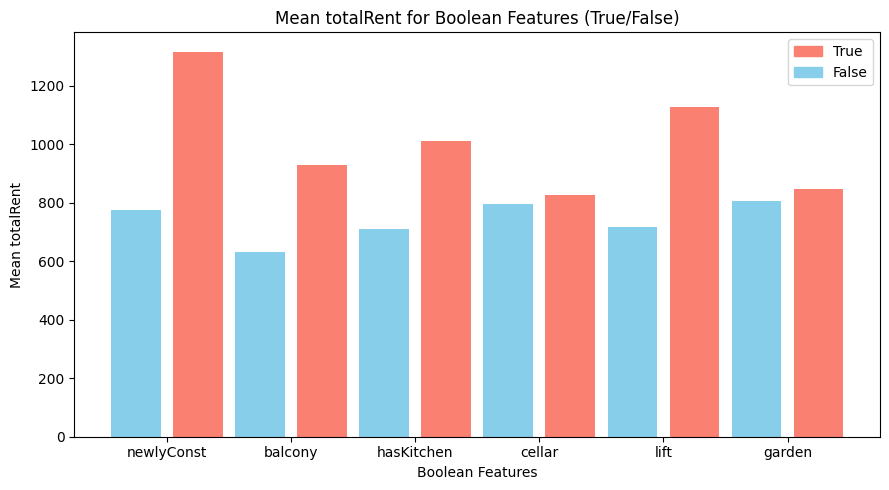

In [18]:
def plot_boolean_means(df, boolean_columns, target_column):
    """
    Creates a single bar chart showing the mean of the target variable for each boolean feature.
    """
    plt.figure(figsize=(9, 5))
    colors = ['skyblue', 'salmon']  # Define colors for True and False

    for i, col in enumerate(boolean_columns):
        means = df.groupby(col)[target_column].mean()
        x_pos = [i * 2, i * 2 + 1]  # Positions for the bars
        plt.bar(x_pos, means, color=[colors[0], colors[1]])

    plt.xticks([i * 2 + 0.5 for i in range(len(boolean_columns))], boolean_columns)  # Adjust x-ticks
    plt.xlabel("Boolean Features")
    plt.ylabel(f"Mean {target_column}")
    plt.title(f"Mean {target_column} for Boolean Features (True/False)")

    # Add legend outside the plot
    false_patch = mpatches.Patch(color=colors[0], label='False')
    true_patch = mpatches.Patch(color=colors[1], label='True')
    plt.legend(handles=[true_patch, false_patch], loc='upper right')

    plt.tight_layout()
    plt.show()


plot_boolean_means(df_clean, BOOLEAN_COLUMNS, 'totalRent')

Both of the graphs above indicate that `cellar` and `garden` variables have no significant impact on the mean `totalRent`. They can as well be excluded from the feature list.

In [19]:
# Fill missing boolean values with False
for col in BOOLEAN_COLUMNS:
    df_clean[col] = df_clean[col].fillna(False)

### Categorical Variables

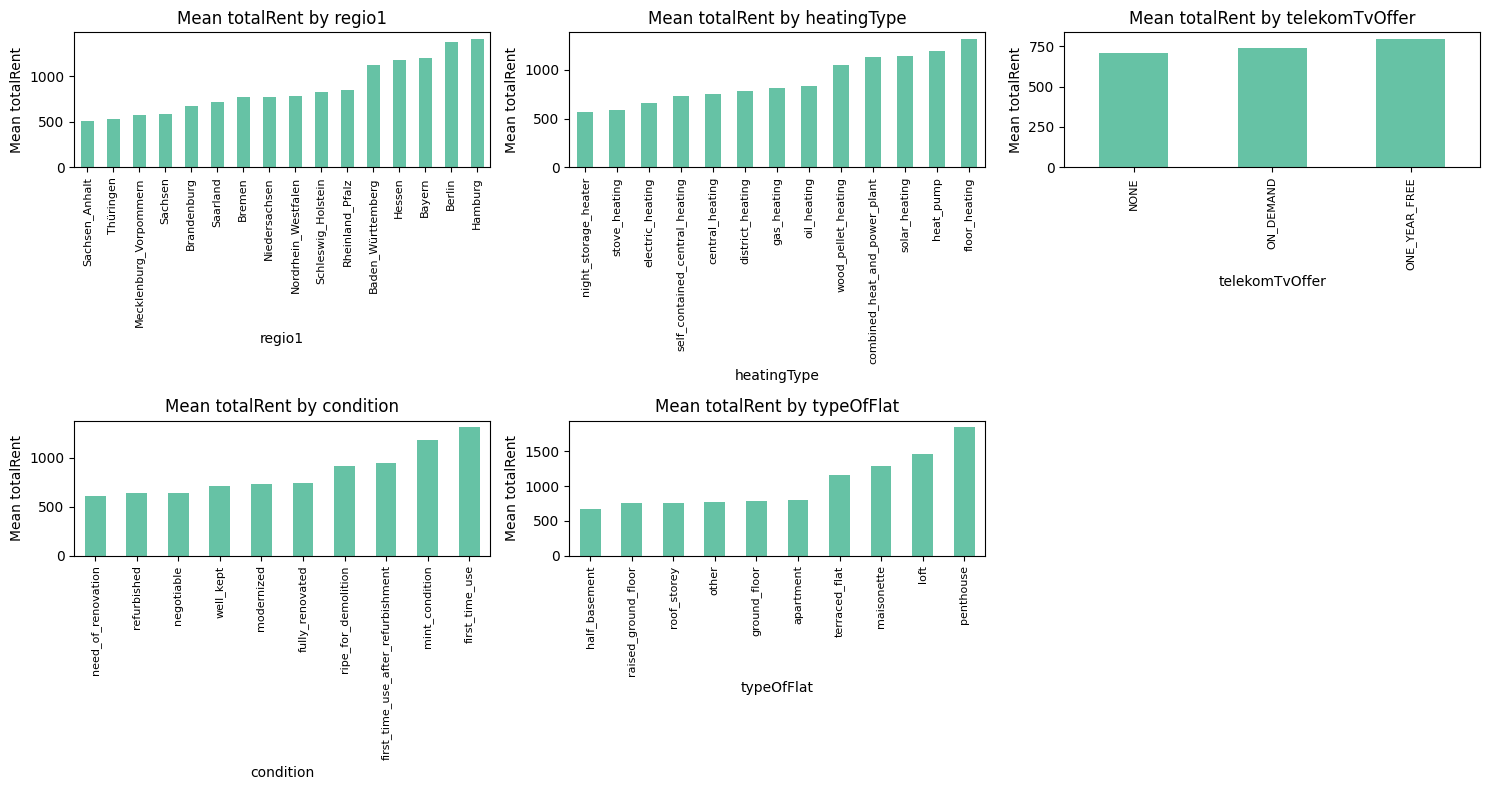

In [20]:
# Exclude geo_plz, streetPlain, regio2 features as they are too big to handle for the plots

def plot_categorical_means(df, categorical_columns, target_column):
    """
    Creates a grid of bar charts showing the mean of the target variable for each categorical feature.
    Excludes specified columns.
    """
    excluded_cols = ['geo_plz', 'streetPlain', 'regio2']
    categorical_columns = [col for col in categorical_columns if col not in excluded_cols]

    num_cols = len(categorical_columns)
    num_rows = (num_cols + 2) // 3  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing


    for i, col in enumerate(categorical_columns):
        if i < len(axes):  # Check to avoid indexing errors
          means = df.groupby(col)[target_column].mean().sort_values()
          means.plot(kind='bar', ax=axes[i], colormap='Set2')
          axes[i].set_title(f'Mean {target_column} by {col}')
          axes[i].set_ylabel(f'Mean {target_column}')
          axes[i].tick_params(axis='x', rotation=90, labelsize=8) # Adjust label rotation and size
          axes[i].set_xlabel(col)
          plt.tight_layout()

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_categorical_means(df_clean, CATEGORICAL_COLUMNS, 'totalRent')

`telekomTVOffer` will be excluded for model trainig, as it does not seem to have a big impact on our target variable.

In [21]:
# Fill missing values in categorical columns with the mode (most frequent value)
for col in CATEGORICAL_COLUMNS:
    df_clean.fillna({col: df[col].mode()[0]}, inplace=True)

### Feature Selection

In [22]:
df_clean.describe(include='all')

,regio1,heatingType,telekomTvOffer,newlyConst,balcony,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,hasKitchen,cellar,livingSpace,condition,streetPlain,lift,typeOfFlat,geo_plz,noRooms,floor,garden,regio2,description,facilities
count,228084,228084,228084,228084,228084,228084.000000,228084.000000,228084.000000,228084.000000,228084,228084,228084.000000,228084,228084,228084,228084,228084,228084.000000,228084.000000,228084,228084,212130,184013
unique,16,13,3,2,2,NaN,NaN,NaN,NaN,2,2,NaN,10,50043,2,10,7369,NaN,NaN,2,419,180579,161916
top,Sachsen,central_heating,ONE_YEAR_FREE,False,True,NaN,NaN,NaN,NaN,False,True,NaN,well_kept,Hauptstraße,False,apartment,9130,NaN,NaN,False,Leipzig,saniertes Mehrfamilienhaus,Laminat
freq,52052,146437,220849,210695,141108,NaN,NaN,NaN,NaN,148309,147504,NaN,112366,54728,173785,141504,1859,NaN,NaN,181976,12578,199,197
mean,NaN,NaN,NaN,NaN,NaN,3.380244,28.920213,814.563052,1966.879786,NaN,NaN,71.436959,NaN,NaN,NaN,NaN,NaN,2.586389,2.056457,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,1.941494,15.231020,560.856124,34.861170,NaN,NaN,26.727238,NaN,NaN,NaN,NaN,NaN,0.904375,1.301106,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,-2.000000,1.000000,1.000000,1856.000000,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.960000,10.000000,470.000000,1957.000000,NaN,NaN,54.000000,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,3.380244,40.000000,650.000000,1966.879786,NaN,NaN,67.000000,NaN,NaN,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,4.600000,40.000000,985.000000,1992.000000,NaN,NaN,86.000000,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000,NaN,NaN,NaN,NaN


Except the Text Features, all the remaining ones has the full count now

In [23]:
selected_features = ['pricetrend', 'yearConstructed','livingSpace', 'noRooms',
                     'regio1', 'heatingType', 'condition','typeOfFlat', 'geo_plz', 'newlyConst',
                     'balcony', 'hasKitchen', 'lift']
X = df_clean[selected_features]
y = df_clean['totalRent']
print("Data Shapes")
print("X:", X.shape)
print("y:", y.shape)

Data Shapes
X: (228084, 13)
y: (228084,)


## Model Training

### Learning Algorithm

I was initially thinking of `XGBoost`, but I found out that `CatBoost` is similar to the `XGBoost` in many ways, but supports categorical features natively, which we have a lot in this dataset.

**XGBoost vs CatBoos Key Differences Comparison Summary:**

1. Handling of Categorical Features

  `XGBoost`

  * Does not natively handle categorical variables. One needs to preprocess categorical features using techniques like one-hot encoding, label encoding, or embedding before feeding them into the model.

  * One-hot encoding can significantly increase the dimensionality of the data, potentially leading to increased computational cost and risk of overfitting.

  `CatBoost`

  * Designed to handle categorical features natively. You can input categorical variables directly without preprocessing.

  * Uses techniques like ordered target statistics and one-hot encoding with a feature combination, which capture categorical information efficiently and reduce the risk of overfitting.

2. Hyperparameter Tuning

  `XGBoost`

  * Requires careful tuning of hyperparameters to achieve optimal performance.

  `CatBoost`

  * Often performs well with default parameters, reducing the need for extensive hyperparameter tuning.



In [24]:
# Define a list of categorical features like before, but include booleans as well.
# This will be needed by the CatBoost algorithm
CATEGORICAL_FEATURES = list(X.select_dtypes(['object', 'bool']).columns)
CATEGORICAL_FEATURES

['regio1',
 'heatingType',
 'condition',
 'typeOfFlat',
 'geo_plz',
 'newlyConst',
 'balcony',
 'hasKitchen',
 'lift']

In [25]:
# Split the data into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

# Print the matrix shapes
print("Training set:", X_tr.shape, y_tr.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (145973, 13) (145973,)
Validation set: (36494, 13) (36494,)
Testing set: (45617, 13) (45617,)


In [26]:
# Create Pool objects for data processing.
# The Pool function is useful for creating dataset objects that are optimized for CatBoost models.
# It enables CatBoost to handle the data efficiently and effectively, particularly when working with categorical features and large datasets.
train_pool = Pool(data = X_train, label = y_train, cat_features = CATEGORICAL_FEATURES)
tr_pool = Pool(data = X_tr, label = y_tr, cat_features = CATEGORICAL_FEATURES)
val_pool = Pool(data = X_val, label = y_val, cat_features = CATEGORICAL_FEATURES)
test_pool = Pool(data = X_test, label = y_test, cat_features = CATEGORICAL_FEATURES)

### Fit model

In [ ]:
# Train the model
model = CatBoostRegressor(
    cat_features = CATEGORICAL_FEATURES,
    loss_function = 'RMSE',
    logging_level = 'Silent',
    iterations = 1500,
    depth = 10,
    task_type="GPU")


start_time = time.time()
# Manual refit model with training dataset, use validation dataset to monitor the performance
model.fit(tr_pool, eval_set = val_pool, plot = True, plot_file = 'training_loss_plot_no_text.html')
end_time = time.time()
print(f"Training done in: {round(end_time - start_time, 2)} seconds")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training time: 99.56 seconds


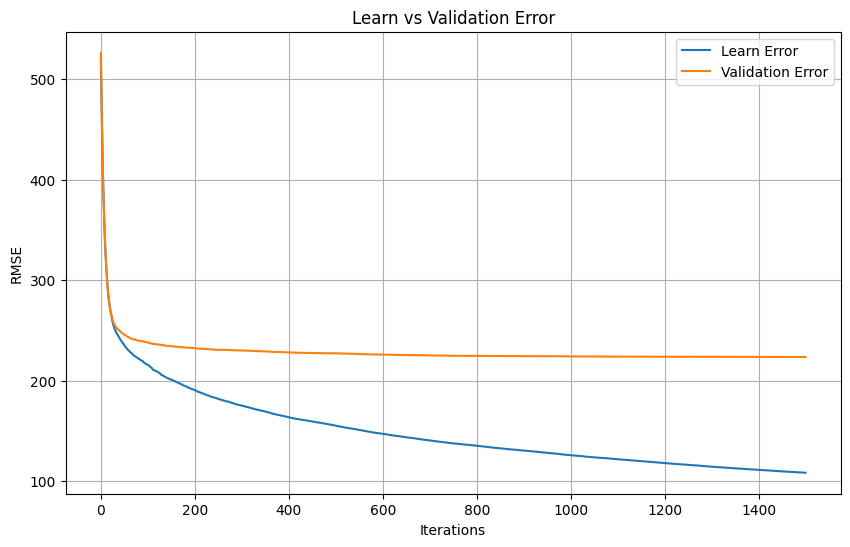

In [30]:
learn_error_df = pd.read_csv('catboost_info/learn_error.tsv', sep='\t')
test_error_df = pd.read_csv('catboost_info/test_error.tsv', sep='\t')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(learn_error_df['iter'], learn_error_df['RMSE'], label='Learn Error')
plt.plot(test_error_df['iter'], test_error_df['RMSE'], label='Validation Error')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Learn vs Validation Error')
plt.legend()
plt.grid(True)
plt.show()

Looks like the validation error converges after 500 iterations

In [31]:
def evaluation_result(model_object,x,y):
    """
    Calculate evaluation metrics for the given model and data.
    """
    y_pred = model_object.predict(x)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    result_df = pd.DataFrame({'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae], 'R2': [r2]})
    return result_df

# Create the result table
print("Training Results on the Validation Set:")
catboost_result = evaluation_result(model, X_val, y_val)
catboost_result

Training Results on the Validation Set:


,MSE,RMSE,MAE,R2
0,49944.30715,223.48223,104.852462,0.842904


### Feature Importance Analysis

In [32]:
# Calculate feature importance scores and sort
importance_scores = model.get_feature_importance()

importance_df = pd.DataFrame({
    'Feature': X_tr.columns,
    'Importance': importance_scores
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
2,livingSpace,28.199041
8,geo_plz,18.485480
4,regio1,11.961380
0,pricetrend,10.383238
1,yearConstructed,7.482199
6,condition,4.644257
12,lift,4.146145
3,noRooms,4.074220
7,typeOfFlat,3.908576
5,heatingType,3.166983


### Test Results

In [33]:
# Filter features with importance score >= 1.0
selected_features = importance_df[importance_df['Importance'] >= 1.0]['Feature'].tolist()
unimportant_features = importance_df[importance_df['Importance'] < 1.0]['Feature'].tolist()

# Update X_train, X_test, X_tr, X_val with selected features
y = df_clean['totalRent']
X = df_clean[selected_features]

# Save a copy of df_clean without unimportant features
df_clean = df_clean.drop(unimportant_features, axis=1)

# Omitting the validation set and learn on the full train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Update categorical features based on the new set of features
CATEGORICAL_FEATURES = list(X.select_dtypes(['object', 'bool']).columns)

# Recreate Pool objects with the updated feature sets
train_pool = Pool(data=X_train, label=y_train, cat_features=CATEGORICAL_FEATURES)
test_pool = Pool(data=X_test, label=y_test, cat_features=CATEGORICAL_FEATURES)

# Retrain the model with the selected features
model = CatBoostRegressor(
    cat_features=CATEGORICAL_FEATURES,
    loss_function='RMSE',
    logging_level='Silent',
    iterations=750,
    depth=10,
    task_type="GPU")

start_time = time.time()
# Do not use the test set for learning evaluation
model.fit(train_pool);
end_time = time.time()
print(f"Training done in: {round(end_time - start_time, 2)} seconds")

# Create result table
print("Result on the Test Set:")
catboost_result = evaluation_result(model, X_test, y_test)
catboost_result

Training done in: 22.89 seconds
Result on the Test Set:


,MSE,RMSE,MAE,R2
0,61442.440175,247.875856,106.270003,0.810399


Similar MAE but slightly worse RMSE and R2 scores on the test set. Maybe a bit of overfitting with the train set is happening. 

PS: Test time is much faster here since the final run for this model are done on a H100. On a T4 it is roughly 40 seconds.

In [35]:
# Save model
file_name = os.path.join(data_directory, "models/CatBoost_model_no_text")
model.save_model(fname=file_name)

## Model Training with Text Data

Firstly, I drop rows with empty `description` or `facilities` columns, as it does not make so much sense to interpolate them. This means, when the text fields are embedded, we will have less data points but with much more features.

In [36]:
# Drop rows where 'description' or 'facilities' are empty
df_clean.dropna(subset=['description', 'facilities'], inplace=True)
df_clean.count(axis=0, numeric_only=False)

regio1                173373
heatingType           173373
telekomTvOffer        173373
pricetrend            173373
telekomUploadSpeed    173373
totalRent             173373
yearConstructed       173373
hasKitchen            173373
cellar                173373
livingSpace           173373
condition             173373
streetPlain           173373
lift                  173373
typeOfFlat            173373
geo_plz               173373
noRooms               173373
floor                 173373
garden                173373
regio2                173373
description           173373
facilities            173373
dtype: int64

In [37]:
# Save the DataFrame to a CSV file
# Can be used later
df_clean.to_csv('df_clean.csv', index=False)  # Set index=False to avoid saving row indices

### Load the embedding model and process the data

Text Embedding Model:

`mixedbread-ai/deepset-mxbai-embed-de-large-v1`

This model is a powerful open-source German/English embedding model developed by Mixedbread in collaboration with deepset. It's built upon `intfloat/multilingual-e5-large` and trained using the AnglE loss.

As of March 2024, the English version of this model, `mixedbread-ai/mxbai-embed-large-v1` achieves SOTA performance for Bert-large sized models on the [MTEB Benchmark](https://huggingface.co/spaces/mteb/leaderboard). It outperforms commercial models like OpenAIs `text-embedding-3-large` model and can match the performance of models 20x its size.

Since the model also supports the Matryoshka Representation Learning (MRL), its embeddings are still useful after dimensionality reduction. At 512 dimensions, over 93% of model performance remains while cutting embedding sizes in half. For this task, I will just use 256 dimensions for simplicity.

[More details](https://www.mixedbread.ai/blog/deepset-mxbai-embed-de-large-v1)

#### Note:
In this section, cells below are commented out since we have already obtained the embeddings and saved them on disk. You can refer to the `backup/GetTextEmbeddings_MxbAI.ipynb` notebook for the actual runs.

In [ ]:
# from sentence_transformers import SentenceTransformer

# # Specify preferred dimensions, default is 1024
# dimensions = 256

# # Load model
# embedding_model = SentenceTransformer("mixedbread-ai/deepset-mxbai-embed-de-large-v1", truncate_dim=dimensions)

In [ ]:
# def create_docs(df):
#   """
#   Add 'passage: ' prefix to each document.
#   This is needed by the mixedbread-ai/deepset-mxbai-embed-de-large-v1 embedding model.
#   """
#   docs = df.tolist()
#   docs = ["passage: " + desc for desc in docs]
#   # Convert to numpy array
#   docs = np.array(docs)
#   return docs

In [ ]:
# description_docs = create_docs(df_clean['description'])
# # Print first 5 elements to verify
# print("Description")
# print(description_docs[:5])
# print("Data array shape: ", description_docs.shape)
# print("--------------------")

# facilities_docs = create_docs(df_clean['facilities'])
# # Print first 5 elements to verify
# print("Facilities")
# print(facilities_docs[:5])
# print("Data array shape: ", facilities_docs.shape)

Description
['passage: Die ebenerdig zu erreichende Erdgeschosswohnung befindet sich in einem gepflegten 8-Familienhaus. Aufgrund der Hanglage bietet sich ein unverbaubarer Blick ins Grüne.'
 'passage: Der Neubau entsteht im Herzen der Dresdner Neustadt.\nDas Baugrundstück befindet sich inmitten einer sehr gefragten Lage.\nNicht nur die zentrale Lage und die schnelle öffentliche\nVerkehrsanbindung durch den zu Fuß erreichbaren Bahnhof, wie auch Nahverkehrsanbindung, sondern auch die Architektur werden diesen\nNeubaukomplex zu einem weiteren Highlight am Dresdner Wohnungsmarkt machen.\nHier entstehen 2- bis 4-Raum Wohnungen mit Wohnflächen zwischen 43 m² und 124 m². Jede Wohnung verfügt über eine Terrasse oder einen Balkon, die Erdgeschosswohnungen erhalten zusätzlich einen Gartenanteil. Die Räumlichkeiten bieten großzügig durchdachte, lichtdurchflutete Räume mit effektiv geschnittenen Grundrissen.'
 'passage: Es handelt sich hier um ein saniertes Mehrfamilienhaus aus dem Jahr 1950. \n\

In [ ]:
# Encode texts

# description_embeddings = embedding_model.encode(description_docs, show_progress_bar=True)
# # Save the file for later use
# np.save('embeddings/description_embeddings.npy', description_embeddings)

# facilities_embeddings = embedding_model.encode(description_docs, show_progress_bar=True)
# # Save the file for later use
# np.save('embeddings/facilities_embeddings.npy', facilities_embeddings)

### Computation Costs


* On a free tier Google Colab GPU runtime, embeddings for these two columns takes more than 8 hours.

* On a much better NVIDIA H100 GPU it takes roughly 20 minutes.

* If one wants to use Open AI's text embedding models:

   Assuming each row (173373 in cleaned data) has roughly 250 tokens for both `description` and `facilities` in total, we would have more than 43 million tokens.
    * `text-embedding-3-small`: $0.44
      
    * `text-embedding-3-large`: $2.82

  Even though the price is rather reasonable, number of total tokens would be much higher than the allowed limit of tokens per day (TPD), which is only 3 million for the Tier 1. The implementation for this approach can be found in `backup/GetTextEmbeddings_OpenAI.ipynb`


### Load embeddings directly from disk

In [39]:
# Load the embeddings from the 'embeddings' folder

description_embeddings = np.load(os.path.join(data_directory, 'embeddings/description_embeddings.npy'))
facilities_embeddings = np.load(os.path.join(data_directory, 'embeddings/facilities_embeddings.npy'))

print("Description Embeddings Shape:", description_embeddings.shape)
print("Facilities Embeddings Shape:", facilities_embeddings.shape)

Description Embeddings Shape: (173373, 256)
Facilities Embeddings Shape: (173373, 256)


In [40]:
print("Prior data shape: ", df_clean.shape)

# Concatenate the embeddings to the DataFrame
embeddings = np.concatenate((description_embeddings, facilities_embeddings), axis=1)
df_embeddings = pd.DataFrame(embeddings)
df_embeddings = df_embeddings.add_prefix('embedding_')

# Concatenate the embeddings DataFrame with the original DataFrame
df_final = pd.concat([df_clean.reset_index(drop=True), df_embeddings.reset_index(drop=True)], axis=1)

# Now df_final contains the original data along with the text embeddings
print("New data shape: ", df_final.shape)

Prior data shape:  (173373, 21)
New data shape:  (173373, 533)


In [41]:
df_final.head(2)

,regio1,heatingType,telekomTvOffer,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,hasKitchen,cellar,livingSpace,condition,streetPlain,lift,typeOfFlat,geo_plz,noRooms,floor,garden,regio2,description,facilities,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,

### Learn a new model

Prepare the new pools

In [79]:
selected_features

['livingSpace',
 'geo_plz',
 'regio1',
 'pricetrend',
 'yearConstructed',
 'lift',
 'condition',
 'noRooms',
 'typeOfFlat',
 'heatingType',
 'hasKitchen']

In [42]:
y = df_final['totalRent']
# Drop the features we do not need
X = df_final.drop(['totalRent', 'description', 'facilities', 'heatingType', 'telekomTvOffer', 'telekomUploadSpeed', 'cellar', 'streetPlain', 'floor', 'garden', 'regio2', ], axis=1)
print("Data Shapes")
print("X:", X.shape)
print("y:", y.shape)

# Split the data into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

# Print the matrix shapes
print("Training set:", X_tr.shape, y_tr.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Data Shapes
X: (173373, 522)
y: (173373,)
Training set: (110958, 522) (110958,)
Validation set: (27740, 522) (27740,)
Testing set: (34675, 522) (34675,)


In [43]:
# Define a list of categorical features like before, but include booleans as well.
# This will be needed by the CatBoost algorithm
CATEGORICAL_FEATURES = list(X.select_dtypes(['object', 'bool']).columns)
CATEGORICAL_FEATURES

['regio1', 'hasKitchen', 'condition', 'lift', 'typeOfFlat', 'geo_plz']

In [44]:
# Create Pool objects for data processing.
train_pool = Pool(data = X_train, label = y_train, cat_features = CATEGORICAL_FEATURES)
tr_pool = Pool(data = X_tr, label = y_tr, cat_features = CATEGORICAL_FEATURES)
val_pool = Pool(data = X_val, label = y_val, cat_features = CATEGORICAL_FEATURES)
test_pool = Pool(data = X_test, label = y_test, cat_features = CATEGORICAL_FEATURES)

In [ ]:
# Train the model
model = CatBoostRegressor(
    cat_features = CATEGORICAL_FEATURES,
    loss_function = 'RMSE',
    logging_level = 'Silent',
    iterations = 1500,
    depth = 10,
    task_type="GPU")


start_time = time.time()
model.fit(tr_pool, eval_set = val_pool, plot = True, plot_file = 'training_loss_plot_w_text.html')
end_time = time.time()
print(f"Training done in: {round(end_time - start_time, 2)} seconds")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training done in: 192.42 seconds


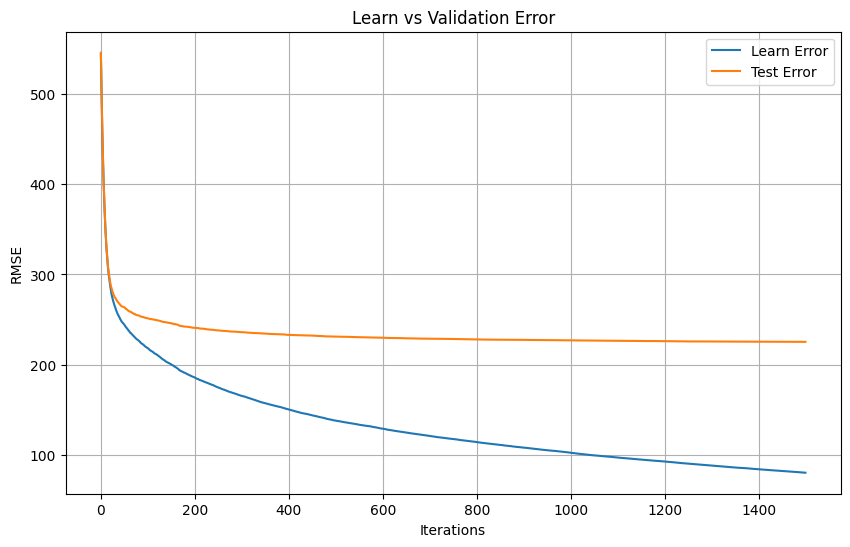

In [47]:
learn_error_df = pd.read_csv('catboost_info/learn_error.tsv', sep='\t')
test_error_df = pd.read_csv('catboost_info/test_error.tsv', sep='\t')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(learn_error_df['iter'], learn_error_df['RMSE'], label='Learn Error')
plt.plot(test_error_df['iter'], test_error_df['RMSE'], label='Test Error')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Learn vs Validation Error')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# Create result table
print("Result on the Validation Set:")
catboost_result = evaluation_result(model, X_val, y_val)
catboost_result

Result on the Validation Set:


,MSE,RMSE,MAE,R2
0,50754.046451,225.286587,107.48317,0.849331


Retrain with the full train set

In [49]:
# Retrain the model with the selected features
model = CatBoostRegressor(
    cat_features=CATEGORICAL_FEATURES,
    loss_function='RMSE',
    logging_level='Silent',
    iterations=750,
    depth=10,
    task_type="GPU")

start_time = time.time()
# Do not use the test set for learning evaluation
model.fit(train_pool);
end_time = time.time()
print(f"Training done in: {round(end_time - start_time, 2)} seconds")

# Create result table
print("Result on the Test Set:")
catboost_result = evaluation_result(model, X_test, y_test)
catboost_result

Training done in: 32.88 seconds
Result on the Test Set:


,MSE,RMSE,MAE,R2
0,47466.992166,217.869209,107.374823,0.853333


Generalizes very well on the test set compared to the previous model. We can see that all RMSE and the R2 improved with the introduction of text embeddings. Although MAE stayed pretty much the same.

PS: Again here the run is done on H100. On T4 it took 92 seconds.

In [51]:
# Save model
file_name = os.path.join(data_directory, "../models/CatBoost_model_w_text")
model.save_model(fname=file_name)

## Alternative approach (Text embeddings only)

In [52]:
y = df_final['totalRent']
X = df_embeddings
print("Data Shapes")
print("X:", X.shape)
print("y:", y.shape)

# Split the data into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

# Print the matrix shapes
print("Training set:", X_tr.shape, y_tr.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)


train_pool = Pool(data = X_train, label = y_train)
tr_pool = Pool(data = X_tr, label = y_tr)
val_pool = Pool(data = X_val, label = y_val)
test_pool = Pool(data = X_test, label = y_test)

Data Shapes
X: (173373, 512)
y: (173373,)
Training set: (110958, 512) (110958,)
Validation set: (27740, 512) (27740,)
Testing set: (34675, 512) (34675,)


In [ ]:
# Train the model
model = CatBoostRegressor(
    loss_function = 'RMSE',
    logging_level = 'Silent',
    iterations = 1000,
    depth = 10,
    task_type="GPU")


start_time = time.time()
model.fit(tr_pool, eval_set = val_pool, plot = True, plot_file = 'training_loss_plot_embeddings_only.html')
end_time = time.time()
print(f"Training done in: {round(end_time - start_time, 2)} seconds")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training done in: 70.4 seconds


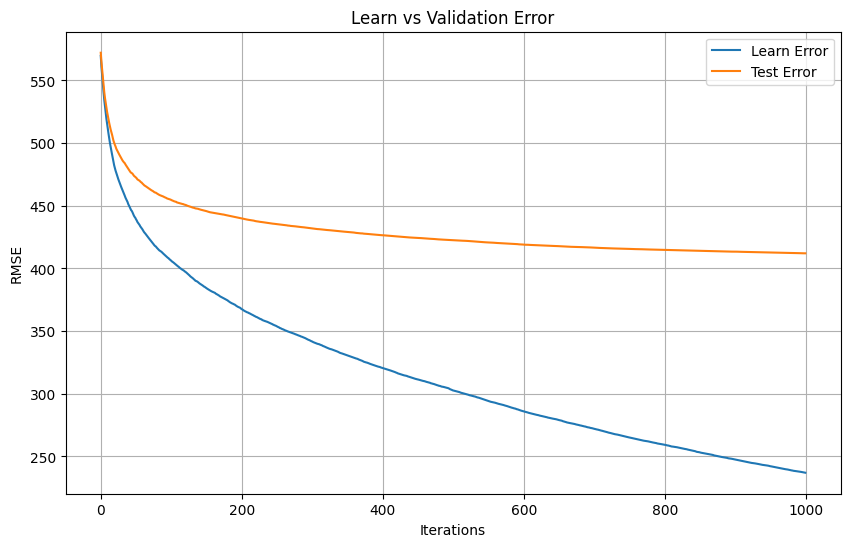

In [54]:
learn_error_df = pd.read_csv('catboost_info/learn_error.tsv', sep='\t')
test_error_df = pd.read_csv('catboost_info/test_error.tsv', sep='\t')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(learn_error_df['iter'], learn_error_df['RMSE'], label='Learn Error')
plt.plot(test_error_df['iter'], test_error_df['RMSE'], label='Test Error')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Learn vs Validation Error')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Create result table
print("Result on the Validation Set:")
catboost_result = evaluation_result(model, X_val, y_val)
catboost_result

Result on the Validation Set:


,MSE,RMSE,MAE,R2
0,169792.303452,412.058617,250.493615,0.495954


Using only text embeddings results in a significantly poorer prediction performance. The structural data is **very important** in our case.

## Final Remarks and Possible Improvements

### Data Processing and Feature Selection

* In the beginning, some features are _kind of_ arbitrarily dropped. In a more ideal scenario, more features could be included for the data pre-processing phase and then maybe for the model training. 
* When handling the missing values, I chose the most straightforward methods (e.g. filling with means or modes). I have not tested other options here. It might be have been useful to employ more advanced techniques, such as linear or polynomial interpolation.
* The outliers in numerical features were replaced with their upper-lower bounds. I have not tested other options here. Maybe it could be, that having many data points on lower and upper bounds of numerical features can be disadvantegous in terms of data distribution.
* To analyze the variance in categorical data in terms of their effect on the mean total rent, I simply went with guesstimation approach, without relying on scientific methods. With more time at hand, one can try to implement ANOVA and/or F-Test for example, to analyze the difference among categories. 

### Model Training and Comparison

| Model | RMSE | MAE | R2 |
| --- | --- | ---| --- |
| CatBoost_model_no_text | 247.88 | **106.27** | 0.810 |
| CatBoost_model_w_text | **217.87** | 107.38 | **0.853** |
| CatBoost_model_text_only (validation set scores) | 412.06 | 250.50 | 0.496 |

* During the training phase, I could do a grid search for cross validation of the hyper-parameters. I just omit this phase to save time and counted on CatBoost's claim that it can work quite well with default hyper-parameters.
* We can see that the predictions of both models are in the +- 100 EUR range of the actual total rent. Which can be considered OK.
* While it is hard to exactly interpret the R2 metric, R2 > 0.85 is generally considered as satisfactory. 
* The second model outperforms the first model and it is able to better generalize on its test set. However, one thing to point out here is that, I used slightly different test sets for these models. The first one is split from a bigger dataset and has 45617 rows, whereas the second one has 34675. So, it might make sense to take into account that the second test split may have easier rental offers to predict. It would have been more appropriate to save the original row indices of the initial test set, and use an identical one for the other model. 